Augmenting training set images...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 117s 3ms/step - loss: 1.7915 - accuracy: 0.3486 - val_loss: 1.4583 - val_accuracy: 0.4672
Epoch 2/20
40000/40000 [==============================] - 103s 3ms/step - loss: 1.3469 - accuracy: 0.5216 - val_loss: 1.0891 - val_accuracy: 0.6183
Epoch 3/20
40000/40000 [==============================] - 105s 3ms/step - loss: 1.1333 - accuracy: 0.5998 - val_loss: 1.0428 - val_accuracy: 0.6269
Epoch 4/20
40000/40000 [==============================] - 99s 2ms/step - loss: 1.0002 - accuracy: 0.6503 - val_loss: 0.9042 - val_accuracy: 0.6830
Epoch 5/20
40000/40000 [==============================] - 100s 2ms/step - loss: 0.9061 - accuracy: 0.6829 - val_loss: 0.8791 - val_accuracy: 0.6962
Epoch 6/20
40000/40000 [==============================] - 105s 3ms/step - loss: 0.8331 - accuracy: 0.7110 - val_loss: 0.8473 - val_accuracy: 0.7056
Epoch 7/20
40000/40000 [==============================] - 98s 2

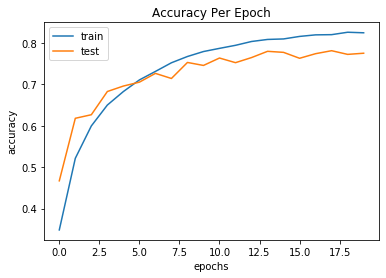

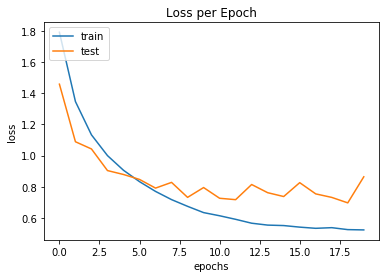

In [3]:
# Performance has been improved with CIFAR-10 by adding data augmentation and using a deeper network.

# Data visualization has also been added.

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import numpy as np

import matplotlib.pyplot as plt
import os

from skimage import io
import shutil


# This code accounts for potential SSL certificate errors when pulling from:
# https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

# CONSTANT
BATCH_SIZE = 128
NB_EPOCH = 20
NB_CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()
NUM_TO_AUGMENT=5

# LOAD DATASET
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
# AUGMENTING
print("Augmenting training set images...")
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# If the "preview" folder exists,  
if (os.path.exists('/preview/') == True):
    # then delete it and all of its contents,
    shutil.rmtree('/preview/')
    # then create a new empty "preview" directory.
    os.mkdir('/preview/')

# Otherwise (if the "preview" folder does not exist),
else: 
    # create a folder called "preview".
    os.mkdir('/preview/')
    
# Add augmented photos to the "preview" directory
xtas, ytas = [], []
for i in range (X_train.shape[0]):
    num_aug = 0
    x = X_train[i] # (3, 32, 32)
    x = x.reshape((1,) + x.shape) # (1, 3, 32, 32)
    
for x_aug in datagen.flow(x, batch_size = 32, save_to_dir='preview', save_prefix='cifar', save_format='jpeg'):
    if num_aug >= NUM_TO_AUGMENT:
        num_aug = 0
        break
    else:
        num_aug += 1
            
# CONVERT TO CATEGORICAL
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# FLOAT AND NORMALIZATION
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# NETWORK
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

# TRAIN
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE)
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

# SAVE MODEL
model_json = model.to_json()
open('cifar10_architecture.json', 'w').write(model_json)

model.save_weights('cifar10_weights.h5', overwrite=True)

# DATA VISUALIZATION
# Visualize accuracy rate as more epochs are completed.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualize rate of loss as more epochs are completed.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# DEVELOPMENT PROCESS

   The original code from the textbook threw two errors which needed to be addressed for the program to function.  First, the code threw an SSL certificate error when pulling from the URL associated with CIFAR-10.  The issue was addressed by adding the following code:
   
```bash
# This code fixes potential SSL certificate errors.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
```

   Then the code threw a syntax error due to the lack of indentation in the augmentation 'for' loop.  After adjusting the indentation appropriately, the final issue which I encountered was a FileNotFound error, which was being thrown because the 'preview' directory referenced in the augmentation code did not exist in the project folder.  After writing code to create a project folder, the program was able to run once but then began throwing a 'FileExists' error which was, of course, due to the fact that the program was trying to create a 'preview' folder when another already existed.  I wrote some additional code to delete any folder called 'preview' if it exists, recursively deleting the contents, and then to create a new empty 'preview' folder.  This made the program work as expected.  The program was able to yield a baseline accuracy of 82.49% on training, of 77.55% on validation, and of 76.77% on the test after 20 epochs.  This is relatively close to the results depicted in our textbook after 40 epochs, which was 82.80% on training, of 78.16% on validation, and of 76.92% on the test. 


# ETHICAL AND PRIVACY IMPLICATIONS

## Could this algorithm result in ethical concerns if it were trained on different types of images?

   There are several ethical concerns which would likely come up if this or a similar algorithm were trained on different types of images.  The use of image recognition software for face-recognition technology raises ethical issues which should certainly not be ignored.  For example, some face recognition models have been found to work with a much higher accuracy for some demographics than others (Fergus, 2024).  According to the ACLU, some models have even shown "[an] error rate for light-skinned men...[of]...0.8%, compared to 34.7% for darker-skinned women" (Fergus, 2024).  If this figure is anywhere near accurate, then the discrepancy in the effectiveness of these algorithms when used to identify individuals of different races is unacceptable and that model needs to be improved before release.  Since more training data tends to increase the accuracy of AI models (Tauscher, 2020), a lack of representation of certain demographics in training data would explain the high error level involved in recognizing darker-skinned women.  One way to solve the issue of high accuracy discrepancy between different skin types would be to add images for each underrepresented demographic to the training data until the number of representations of each skin type class is relatively equal. 
   
   Other ethical concerns which could result from this algorithm relate to its potential use-cases.  For example, as of 2019 the US Army is developing smart weapon systems which will likely use image recognition (Cooke, 2019) which will help them to differentiate between enemy targets and civilians.  The presence of smart weapon systems which use AI to identify and eliminate targets would mean that too low of an accuracy could result in injury or death to civilians.  Even if algorithms are precise enough to avoid accidental injuries or casualties, the extent to which tyrants and corrupt politicians could use such software to subjugate populations should also be taken into consideration.  That being said, current technology has made it relatively easy for anyone around the world to learn how to make similar models, and to refrain from developing them further for fear that they might fall into the wrong hands would give current or potential enemy forces the chance to gain an advantage through technological superiority in the area of AI.  In order to address the valid concern of accurate AI systems being used for malicious purposes, it is of the utmost importance that organizations and governments in the free world stay at the forefront of AI technology in order to address future challenges from enemy nations.
   
   The use of such technology by governments domestically is another possibility which could cause ethical concerns.  Police forces in the United States are currently using face recognition software (Cooke, 2019) for a variety of different purposes, including the identification of suspects from crime scene photos (United States Government Accountability Office, 2024).  Considering the potential for large discrepancies in accuracy in certain demographic categories such as skin tone (Fergus, 2024), it is easy to see how the use of algorithms with this type of bias could lead to injustices against law-abiding Americans.   
   
   
## Could this algorithm result in privacy concerns if it were trained on different types of images?
   
   The use of such an algorithm for facial recognition also raises important privacy concerns.  One such concern which has been raised is the possibility that the organizations which deploy facial recognition systems will be able to collect private or sensitive data from individuals without their consent (Mineo, 2023).  In her 2020 *New York Times* article on a company called Clearview AI, Hill describes how the organization has created an application which allows one to "take a picture of a person, upload it and...see public photos of that person...[the]...backbone is a database of more than three billion images..scraped from Facebook, YouTube, Venmo and millions of other websites" (Hill, 2020).  The idea that what a person puts on social media could be so easily accessed, downloaded and processed is probably not what most people think about when they post photos of themselves online.  Another similar application called Pimeyes which, upon taking a photo of a person, can pull photos and links from across the internet with astounding accuracy (Bowers & Zittrain, 2020, as cited in Mineo, 2023).  The app is available to the public for $30 a month (Bowers & Zittrain, 2020, as cited in Mineo, 2023).  

   While facial recognition was the main focus in most of my research on privacy concerns related to image recognition, this type of software could also be used to identify buildings (picarta, 2025), vehicles (CarNet, n. d.), and other types of private property.  Images of inanimate objects, such as a subject's home or car, could add to the volume of private or sensitive information acquired by private or public organizations from individuals without their consent. 
   
   For organizations that want to use image recognition technology ethically, one way to address these privacy issues would be to implement a method for preventing unintended memorization (Carlini et al., 2018).  "Unintended memorization occurs when trained neural networks may reveal the presence of out-of-distribution training data...that is irrelevant...and...unhelpful to improving model accuracy" (Carlini et al., 2018).  Since unintentionally memorized data might include sensitive information which users would not want to disclose publicly (Carlini et al., 2020), strategies to mitigate unintended memorization would reduce the overall amount of private information which is collected from individuals without their consent. 
   
   It is also important to consider the possibility of latent bias which is hard to predict the presence of before implementation (DeCamp & Lindvall, 2020).  "Regulatory frameworks governing AI and machine learning algorithms must explicitly include reference to monitoring for biases in performance, including those that emerge" (DeCamp & Lindvall, 2020).  "Engag[ing] all...stakeholders in the design and implementation of AI" (DeCamp & Lindvall, 2020) is another great way to reduce latent bias as it reveals itself through feedback upon each iterative deployment.  
   
   
## Addressing concerns

   As mentioned above, the issue of bias caused by the underrepresentation of data depicting certain demographics in testing data sets can be addressed by adding more data which represents those demographics.  The possibility of image recognition technology being used to do harm can be mitigated by assuring that free nations remain at the forefront of image recognition technology.  The possibility of bias present in facial recognition algorithms used by law enforcement causing injustice can be mitigated by assuring that significant demographic-based accuracy discrepancies are not present before the deployment of a model.  Approaches which align with the principles of 'ethics by design' and 'responsible research and innovation' (RRI) and 'ethics by design' will help design and development teams to focus on addressing and mitigating bias at all stages of the development process (Brey & Dainow, 2023).  
   
   While techniques like unintentional memorization mitigation could help to reduce the amount of personal information which is collected from individuals without their consent, I believe that countering technology could be the most effective way for individuals to protect their privacy and prevent image recognition software from being used on them.  For example, social  media companies could gain an edge over their competition by implementing measures which make it harder for algorithms and online tools to access the photos and the information of their users.  Perhaps some technology could be developed which sends a signal to nearby image recognition devices that the person being recorded does not give their consent for their image to be saved or used, and legislation could be passed to require facial or image recognition systems to scan for such signals. 
It's difficult to say exactly what kind of technology would be effective at preventing faces from being scanned, but I believe that the private sector (along with some help from the state perhaps) could be the most effective force in preventing data from being collected from individuals without their consent.


## Sources 

Bowers, J., & Zittrain, J. (2020, April 14). *A Start-Up is Using Photos to ID You: Big Tech Can Stop It From Happening Again*. The Washington Post. https://www.washingtonpost.com/outlook/2020/04/14/tech-start-up-is-using-photos-id-you-big-tech-could-have-stopped-them/

Brey, P., & Dainow, B. (2023, September 21). Ethics by Design for Artificial Intelligence. *AI Ethics 4*, 1265–1277. https://doi.org/10.1007/s43681-023-00330-4

Carlini, N., Erlingsson, U., Knos, J., Liu, C., & Song, D. (2018, February 22). *The Secret Sharer: Evaluating and Testing Unintended Memorization in Neural Networks*. Cornell University. https://arxiv.org/abs/1802.08232  

CarNet. (n. d.). *How It Works*. https://carnet.ai/make-model-recognition-api 

Cooke, G. (2019, June 11). *Magic Bullets: The Future of Artificial Intelligence in Weapons Systems.* United States Army. https://www.army.mil/article/223026/magic_bullets_the_future_of_artificial_intelligence_in_weapons_systems

DeCamp, M., & Lindvall, C. (2020, June 18). Latent bias and the implementation of artificial intelligence in medicine. *Journal of the American Medical Informatics Association, 27*(12). https://doi.org/10.1093/jamia/ocaa094

Fergus, R. (2024, February 29). *Facial recognition remains largely ungoverned - and dangerous - in Minnesota.* ACLU. https://www.aclu-mn.org/en/news/biased-technology-automated-discrimination-facial-recognition 

Hill, K. (2020, Jan 21). *The Secretive Company That Might End Privacy as We Know It*. The New York Times. https://link.gale.com/apps/doc/A611773186/GIC?u=nhc_main&sid=ebsco&xid=602284b3 

Mineo, L. (2023, October 26). *How facial-recognition app poses threat to privacy, civil liberties*. The Harvard Gazette. https://news.harvard.edu/gazette/story/2023/10/how-facial-recognition-app-poses-threat-to-privacy-civil-liberties/

Picarta. (2025). *Find Photo Location with Picarta V2*. https://picarta.ai/how-to-use 

Tauscher, J. (2020, July 22). *More Data? Or a More Powerful Model?* Medium. https://medium.com/@john.l.tauscher/more-data-or-a-more-powerful-model-7e45fee2e6d8 

United States Government Accountability Office. (2024, March 7). *Facial Recognition Technology:
Federal Law Enforcement Agency Efforts Related to Civil Rights and Training*. https://www.gao.gov/products/gao-24-107372 
